### Deep Learning in the Eye Tracking World 
#### the tutorial presented during ETRA 2021 (https://etra.acm.org/2021/acceptedtutorials.html)
#### the code downloaded from: https://github.com/kasprowski/etra2021
@author: pawel@kasprowski.pl


# Test the model created in eye_to_gaze.ipynb notebook

In [2]:
import os
import cv2
from sklearn.metrics import mean_absolute_error
from tensorflow.python.keras.models import load_model
import numpy as np
import tensorflow as tf

### Download the dataset

In [6]:
import requests
import zipfile
r = requests.get("http://www.kasprowski.pl/etra2021/eye_left.zip", allow_redirects=True)
open('eye_left.zip', 'wb').write(r.content)
print("Downloaded eye_left.zip")
with zipfile.ZipFile("eye_left.zip","r") as zip_ref:
    zip_ref.extractall("eye_left")
print("Uzipped to /eye_left directory")

Downloaded eye_left.zip
Uzipped to /eye_left directory


### Download the model

In [5]:
import requests
r = requests.get("http://www.kasprowski.pl/etra2021/eye2gaze_model.h5", allow_redirects=True)
open('eye2gaze_model.h5', 'wb').write(r.content)
print("Downloaded eye2gaze_model.h5")

Downloaded eye2gaze_model.h5


### Load all images from /eye_left
The label is derived from file name

In [7]:
def load_images(indir):
    samples = []
    labels = []
    for imagePath in os.listdir(indir):
        #print(imagePath)
        image = cv2.imread("{}/{}".format(indir,imagePath))
        image = preprocess(image)
        samples.append(image)
        label = np.zeros((2))
        label[0] = float(imagePath[0:imagePath.find("_")])
        label[1] = float(imagePath[imagePath.find("_")+1:imagePath.find(".")])
        #print(label[0],label[1])
        labels.append(label)
        
    samples = np.array(samples, dtype="float")
    labels = np.array(labels)
    return samples,labels

# resizes each image to (64,64) and then masks the image with ellipse
def preprocess(image):
    image = cv2.resize(image, (64, 64))
    mask = np.zeros_like(image)
    rows, cols,_ = mask.shape
    mask=cv2.ellipse(mask, center=(rows//2, cols//2), axes=(28,14), 
                     angle=0, startAngle=0, endAngle=360, 
                     color=(255,255,255), thickness=-1)
    result = np.bitwise_and(image,mask)
    result = result[14:64-14,:]
    return result

### Calculate gaze coordinates for all images and save results in the image

In [9]:
testSamples,testLabels = load_images("eye_left")

model = load_model("eye2gaze_model.h5") ### add the correct model name!!!
#model = load_model("eye_models/model.01-50.66.h5") ### add the correct model name!!!
predictions = model.predict(testSamples)

results = np.zeros((800,1500,3))

# create an image with current predictions
for i in range(testSamples.shape[0]):
    cv2.circle(results,(int(testLabels[i,0]),int(testLabels[i,1])),10,(0,255,0),2)
    cv2.circle(results,(int(predictions[i,0]),int(predictions[i,1])),10,(255,0,0),2)
    cv2.line(results, 
             (int(predictions[i,0]),int(predictions[i,1])),
             (int(testLabels[i,0]),int(testLabels[i,1])), 
             (255,0,0),2
             )
cv2.imwrite("test_model.jpg",results)
 

True

### Show results

Final MAE: 40.72133978366852


(-0.5, 1499.5, 799.5, -0.5)

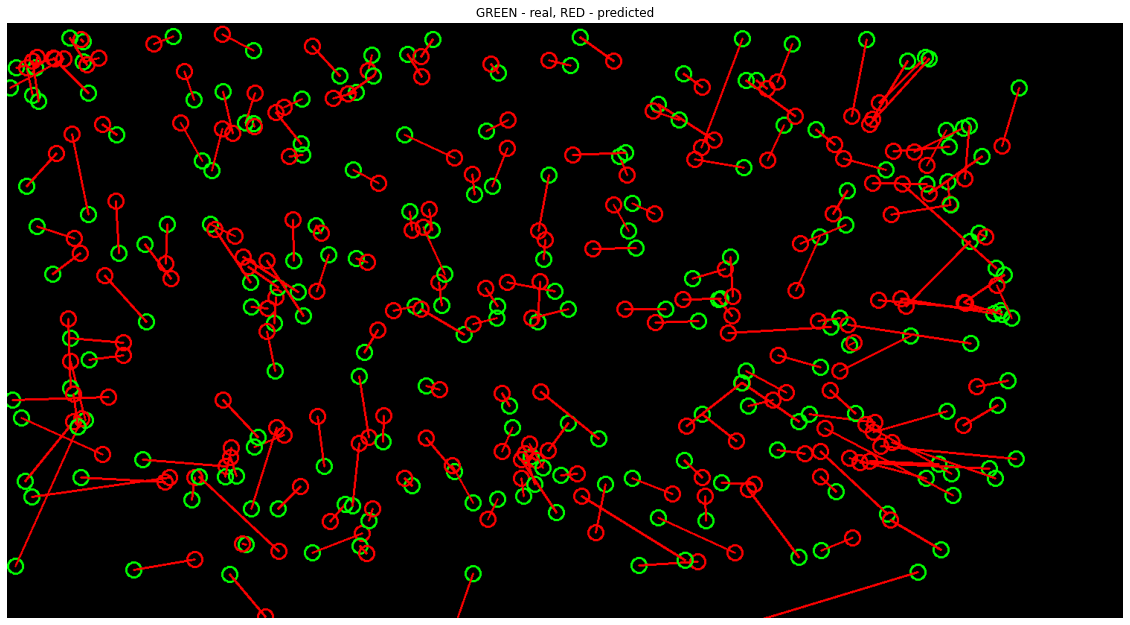

In [10]:
print("Final MAE: {}".format(mean_absolute_error(testLabels,predictions)))    

results = results/255
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 20))
plt.imshow(results)
plt.title("GREEN - real, RED - predicted")
plt.axis("off")  